In [2]:
import torchvision
import torch
from torch.utils.data import Subset
import torchvision.transforms.functional as F

transform=torchvision.transforms.Compose([ 
    torchvision.transforms.Lambda(lambda img: F.crop(img, top=2, left=2, height=img.height - 4, width=img.width - 4)),
    torchvision.transforms.Resize((20, 20), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda tensor: (tensor * 10).float())
])

train_dataset = torchvision.datasets.MNIST("data/mnist", download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.MNIST("data/mnist", download=True, train=False, transform=transform)

train_subset = Subset(train_dataset, range(60000))  
test_subset = Subset(train_dataset, range(10000))  
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=2048, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.07MB/s]


In [4]:
G_MAX_P = [45.553, 48.860, 48.911]
G_MAX_D = [20.145, 44.382, 44.382]
G_MIN_P = [1.515,  2.442,  2.317]
G_MIN_D = [1.761,  8.274,  8.374]
AP =  [0.673,  0.204,  0.018] # concern
AD =  [0.107,  0.032,  0.032]
BP =  [-0.597, -0.329, 0.496] # concern
BD =  [3.649,  5.839,  5.839]

In [68]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F2

start_p = 15 * 10**-9 # Start at around 15nS
start_d = 15 * 10**-9 
def mysign(x): return (x > 0).float()

def cosine_similarity_scalar(t1, t2):
    t1 = t1 / torch.norm(t1)
    t2 = t2 / torch.norm(t2)
    return F2.cosine_similarity(t1.flatten(), t2.flatten(), dim=0).item()


def count_sign_difference(tensor1, tensor2):
    # Compute sign of each tensor (-1 for negative, 0 for zero, 1 for positive)
    sign1 = torch.sign(tensor1)
    sign2 = torch.sign(tensor2)
    # Count where the signs differ
    num_different = torch.sum(sign1 != sign2).item()
    return num_different

class MnistClassifier(nn.Module):
    def __init__(self, hidden_dim): 
        super(MnistClassifier, self).__init__()
        self.in_dim = 400
        self.hidden_dim = hidden_dim
        self.out_dim = 10
        
        self.flat = nn.Flatten()
        self.Ron = 5 * (10 ** 6)
        self.act = nn.LeakyReLU(0.1)

        self.alpha_P = 0 
        self.alpha_D = 0 
        self.beta_P = 0 
        self.beta_D = 0 
        self.G_max_p = 0 
        self.G_min_p = 0 
        self.G_max_d = 0 
        self.G_min_d = 0 

        self.update_setup(0)

        self.g_plus_1  = nn.Parameter( torch.rand((self.in_dim,self.hidden_dim ))*(10**-9) + start_p)
        self.g_minus_1 = nn.Parameter(-torch.rand((self.in_dim,self.hidden_dim ))*(10**-9) + start_d)
        self.g_plus_2  = nn.Parameter( torch.rand((self.hidden_dim,self.out_dim))*(10**-9) + start_p)
        self.g_minus_2 = nn.Parameter(-torch.rand((self.hidden_dim,self.out_dim))*(10**-9) + start_d)


    def function_P(self, x): return self.alpha_P * torch.exp(-1*self.beta_P*((x-self.G_min_p)/(self.G_max_p-self.G_min_p)))
    def function_D(self, x): return self.alpha_D * torch.exp(-1*self.beta_D*((self.G_max_d-x)/(self.G_max_d-self.G_min_d)))
    def compute_gradient_P(self, params, deltas): return mysign(deltas) * self.function_P(params)
    def compute_gradient_D(self, params, deltas): return mysign(-deltas) * self.function_D(params)




    
    # CHANGES THE GRANULARITY
    def update_setup(self, I):
        self.G_max_p = G_MAX_P[I] * (10 ** -9)
        self.G_max_d = G_MAX_D[I] * (10 ** -9) 
        self.G_min_p = G_MIN_P[I] * (10 ** -9)
        self.G_min_d = G_MIN_D[I] * (10 ** -9)
        self.alpha_P = AP[I] 
        self.beta_P  = BP[I] 
        self.alpha_D = AD[I] 
        self.beta_D  = BD[I] 
            



    
    # SHIFTS THE PLUS AND MINUS WEIGHTS TO ALLOW FOR MORE CHANGES IN LIGHT OF CLIPPING
    def refresh_func(self, plus_tensor, minus_tensor): 
        clipped_count = 0
        W = (plus_tensor - minus_tensor).clone()
        
        # FOR CORRECTING G_PLUS BEING MAXIMUM 
        mask = (plus_tensor  > self.G_max_p * torch.ones_like(plus_tensor)).int()
        inv_mask = 1 - mask
        with torch.no_grad():
            new_minus = minus_tensor * inv_mask + self.G_min_d * mask
            new_plus = plus_tensor * inv_mask + (W + self.G_min_d) * mask            
            minus_tensor.copy_(new_minus)
            plus_tensor.copy_(new_plus)
        
        # FOR CORRECTING G_MINUS BEING MAXIMUM 
        mask = (minus_tensor > self.G_max_d * torch.ones_like(minus_tensor)).int()
        inv_mask = 1 - mask
        with torch.no_grad():
            new_plus = plus_tensor * inv_mask + self.G_min_p * mask     
            new_minus = minus_tensor * inv_mask + (-W + self.G_min_p) * mask     
            minus_tensor.copy_(new_minus)
            plus_tensor.copy_(new_plus)

        return W 
    




    # SHIFTS WEIGHTS AND CLIP 
    def refresh(self): 
        W1_before = self.refresh_func(self.g_plus_1, self.g_minus_1)
        W2_before = self.refresh_func(self.g_plus_2, self.g_minus_2)

        err1 = torch.norm((self.g_plus_1 - self.g_minus_1) - W1_before).item()
        err2 = torch.norm((self.g_plus_2 - self.g_minus_2) - W2_before).item()
        error = err1 + err2 
        
        with torch.no_grad():  
            self.g_plus_1.data.clamp_( self.G_min_p, self.G_max_p)
            self.g_minus_1.data.clamp_(self.G_min_d, self.G_max_d)
            self.g_plus_2.data.clamp_( self.G_min_p, self.G_max_p)
            self.g_minus_2.data.clamp_(self.G_min_d, self.G_max_d)

        clipped_count1 = 0 
        mask = torch.isclose(self.g_plus_1,  self.G_max_p * torch.ones_like(self.g_plus_1), atol=1e-15).int()
        clipped_count1 += torch.sum(mask).item()
        mask = torch.isclose(self.g_minus_1, self.G_max_d * torch.ones_like(self.g_minus_1),  atol=1e-15).int()
        clipped_count1 += torch.sum(mask).item()
        clipped_count1 = clipped_count1 / torch.tensor(mask.shape).prod().item()

        clipped_count2 = 0 
        mask = torch.isclose(self.g_plus_2,  self.G_max_p * torch.ones_like(self.g_plus_2), atol=1e-15).int()
        clipped_count2 += torch.sum(mask).item()
        mask = torch.isclose(self.g_minus_2, self.G_max_d * torch.ones_like(self.g_minus_2),  atol=1e-15).int()
        clipped_count2 += torch.sum(mask).item()
        clipped_count2 = clipped_count2 / torch.tensor(mask.shape).prod().item()

        return clipped_count1, clipped_count2





    # FORWARD PROPAGATION 
    def forward(self, x): 
        x = self.flat(x)
        self.W_1 = self.g_plus_1 - self.g_minus_1
        if(torch.is_grad_enabled()): self.W_1.retain_grad()
        self.h_1 = torch.matmul(x,self.W_1)
        self.y_1 = self.h_1 * self.Ron 

        self.y_1 = self.act(self.y_1)
        self.W_2 = self.g_plus_2 - self.g_minus_2
        if(torch.is_grad_enabled()): self.W_2.retain_grad()
        self.h_2 = torch.matmul(self.y_1,self.W_2)
        self.y_2 = self.h_2 * self.Ron 
        return self.y_2
    



    
    # ANALOG UPDATE RULE 
    def update_parameters(self): 
        pseudo = True 
        noise_dev = 0.08
        use_noisy = False
        
        # UPDATE CACLULATION 
        with torch.no_grad():
            ##############################################################################################################
            target_updates1 = -0.05 * self.W_1.grad * torch.norm(self.W_1) / (torch.norm(self.W_1.grad) + 10**-20)
            noise1 = noise_dev * torch.randn_like(target_updates1) * torch.norm(target_updates1)
            
            # INCREASING PULSE COUNT FOR P1
            target_updates_P1 = (target_updates1 > 0).int() * target_updates1 
            noisy_updates_P1 = (target_updates1 + noise1 > 0).int() * (target_updates1 + noise1) 
            pseudo_updates_P1 = self.compute_gradient_P(self.g_plus_1.data, target_updates1) * (10 ** -9)
            if(use_noisy): pseudo_updates_P1 = noisy_updates_P1
            if(pseudo): self.g_plus_1 += pseudo_updates_P1
            else: self.g_plus_1 += target_updates_P1

            # INCREASING PULSE COUNT FOR D1
            target_updates_D1 = -1 * (target_updates1 < 0).int() * target_updates1 
            noisy_updates_D1 = -1 * (target_updates1 + noise1 < 0).int() * (target_updates1 + noise1) 
            pseudo_updates_D1 = self.compute_gradient_D(self.g_minus_1.data, target_updates1) * (10 ** -9)
            if(use_noisy): pseudo_updates_D1 = noisy_updates_D1
            if(pseudo): self.g_minus_1 += pseudo_updates_D1  
            else: self.g_minus_1 += target_updates_D1  
            ##############################################################################################################
      
            ##############################################################################################################
            target_updates2 = -0.05 * self.W_2.grad * torch.norm(self.W_2) / (torch.norm(self.W_2.grad) + 10**-20)
            noise2 = noise_dev * torch.randn_like(target_updates2) * torch.norm(target_updates2)

            # INCREASING PULSE COUNT FOR P1
            target_updates_P2 = (target_updates2 > 0).int() * target_updates2 
            noisy_updates_P2 = (target_updates2 + noise2 > 0).int() * (target_updates2 + noise2) 
            pseudo_updates_P2 = self.compute_gradient_P(self.g_plus_2.data, target_updates2) * (10 ** -9)
            if(use_noisy): pseudo_updates_P2 = noisy_updates_P2
            if(pseudo): self.g_plus_2 +=  pseudo_updates_P2
            else: self.g_plus_2 +=  target_updates_P2

            # INCREASING PULSE COUNT FOR D1
            target_updates_D2 = -1 *(target_updates2 < 0).int() * target_updates2 
            noisy_updates_D2 = -1 *(target_updates2 + noise2 < 0).int() * (target_updates2 + noise2) 
            pseudo_updates_D2 = self.compute_gradient_D(self.g_minus_2.data, target_updates2) * (10 ** -9)
            if(use_noisy): pseudo_updates_D2 = noisy_updates_D2
            if(pseudo): self.g_minus_2 +=  pseudo_updates_D2
            else: self.g_minus_2 +=  target_updates_D2
            ##############################################################################################################

            # TAKING MEASUREMENTS
            gradient_mean_p1 = torch.norm(target_updates_P1).item()
            gradient_mean_p2 = torch.norm(target_updates_P2).item()
            pseudo_mean_p1 = torch.norm(pseudo_updates_P1).item()
            pseudo_mean_p2 = torch.norm(pseudo_updates_P2).item()
            p1_mean = torch.mean(self.g_plus_1).item()
            d1_mean = torch.mean(self.g_minus_1).item()
            p2_mean = torch.mean(self.g_plus_2).item()
            d2_mean = torch.mean(self.g_minus_2).item()
            weight_means = (p1_mean, d1_mean, p2_mean, d2_mean)

            p1_sim = cosine_similarity_scalar(target_updates_P1, pseudo_updates_P1)
            d1_sim = cosine_similarity_scalar(target_updates_D1, pseudo_updates_D1)
            p2_sim = cosine_similarity_scalar(target_updates_P2, pseudo_updates_P2)
            d2_sim = cosine_similarity_scalar(target_updates_D2, pseudo_updates_D2)
            similarities = (p1_sim, d1_sim, p2_sim, d2_sim)
            
        clipped1, clipped2 = self.refresh()
        return gradient_mean_p1, gradient_mean_p2, pseudo_mean_p1, pseudo_mean_p2, weight_means, clipped1, clipped2, similarities
    

In [74]:
from tqdm import tqdm 

device = torch.device("cuda")
model = MnistClassifier(50)
model = model.to(device)
model.update_setup(2)
model.refresh()

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters())
losses, accuracies = [], []
GRADIENT_MEAN_P1, GRADIENT_MEAN_P2, PSEUDO_MEAN_P1, PSEUDO_MEAN_P2 = [],[],[],[]
CLIPPED1, CLIPPED2 = [], []
SIMILARITIES = []
WEIGHT_MEANS = []

# BASELINE ACCURACY EVALUATION
def test_acc(): 
    total_correct = 0
    total_predictions = 0 
    model.eval()
    with torch.no_grad():
        for test_imgs, test_labels in test_loader: 
            test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
            test_preds = model(test_imgs)
            predicted = torch.argmax(test_preds, dim=1)
            total_correct += (predicted == test_labels).sum().item()
            total_predictions += test_labels.size(0)
    accuracy = total_correct / total_predictions
    accuracies.append(accuracy)
    model.train()  # Back to training mode
    return accuracy 
test_acc()


# TRAINING LOOP 
num_epochs = 60
num_batches = len(train_loader)
eval_interval = max(1, num_batches // 1) 
for epoch in range(num_epochs):
    
    # if(epoch == 1): model.update_setup(0)
    # model.refresh()
        
    total_loss = 0 
    for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader)):
    # for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)

        labels = 5 * torch.nn.functional.one_hot(labels, num_classes=10).float()
        loss = criterion(preds, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())

        # GET MEASUREMENTS
        gradient_mean_p1, gradient_mean_p2, pseudo_mean_p1, pseudo_mean_p2, weight_means, clipped1, clipped2, similarities = model.update_parameters()
        GRADIENT_MEAN_P1.append(gradient_mean_p1), GRADIENT_MEAN_P2.append(gradient_mean_p2)
        PSEUDO_MEAN_P1.append(pseudo_mean_p1), PSEUDO_MEAN_P2.append(pseudo_mean_p2)
        WEIGHT_MEANS.append(weight_means)
        CLIPPED1.append(clipped1), CLIPPED2.append(clipped2)
        SIMILARITIES.append(similarities)

        # evaluate accuracy
        if (batch_idx + 1) % eval_interval == 0: accuracy = test_acc()
        
            
    print(f"Epoch {epoch}, Loss: {total_loss}, Accuracy: {accuracy}, {accuracies[-10:]}") 
    # losses.append(total_loss)


100%|██████████| 938/938 [00:15<00:00, 62.29it/s]


Epoch 0, Loss: 2278.7965581417084, Accuracy: 0.1001, [0.0863, 0.1001]


100%|██████████| 938/938 [00:14<00:00, 62.71it/s]


Epoch 1, Loss: 2230.461237668991, Accuracy: 0.1107, [0.0863, 0.1001, 0.1107]


100%|██████████| 938/938 [00:14<00:00, 62.95it/s]


Epoch 2, Loss: 2179.1792452335358, Accuracy: 0.3033, [0.0863, 0.1001, 0.1107, 0.3033]


100%|██████████| 938/938 [00:15<00:00, 62.51it/s]


Epoch 3, Loss: 2041.8968994617462, Accuracy: 0.4969, [0.0863, 0.1001, 0.1107, 0.3033, 0.4969]


100%|██████████| 938/938 [00:15<00:00, 62.49it/s]


Epoch 4, Loss: 1855.2418230772018, Accuracy: 0.5766, [0.0863, 0.1001, 0.1107, 0.3033, 0.4969, 0.5766]


100%|██████████| 938/938 [00:15<00:00, 62.36it/s]


Epoch 5, Loss: 1700.6920510530472, Accuracy: 0.6551, [0.0863, 0.1001, 0.1107, 0.3033, 0.4969, 0.5766, 0.6551]


100%|██████████| 938/938 [00:15<00:00, 61.78it/s]


Epoch 6, Loss: 1605.5669971704483, Accuracy: 0.7016, [0.0863, 0.1001, 0.1107, 0.3033, 0.4969, 0.5766, 0.6551, 0.7016]


100%|██████████| 938/938 [00:15<00:00, 62.24it/s]


Epoch 7, Loss: 1581.1522146463394, Accuracy: 0.7295, [0.0863, 0.1001, 0.1107, 0.3033, 0.4969, 0.5766, 0.6551, 0.7016, 0.7295]


100%|██████████| 938/938 [00:15<00:00, 61.57it/s]


Epoch 8, Loss: 1604.9691598415375, Accuracy: 0.75, [0.0863, 0.1001, 0.1107, 0.3033, 0.4969, 0.5766, 0.6551, 0.7016, 0.7295, 0.75]


100%|██████████| 938/938 [00:14<00:00, 62.67it/s]


Epoch 9, Loss: 1626.7098542451859, Accuracy: 0.7691, [0.1001, 0.1107, 0.3033, 0.4969, 0.5766, 0.6551, 0.7016, 0.7295, 0.75, 0.7691]


100%|██████████| 938/938 [00:15<00:00, 61.98it/s]


Epoch 10, Loss: 1669.5322737693787, Accuracy: 0.7875, [0.1107, 0.3033, 0.4969, 0.5766, 0.6551, 0.7016, 0.7295, 0.75, 0.7691, 0.7875]


100%|██████████| 938/938 [00:14<00:00, 62.57it/s]


Epoch 11, Loss: 1699.0985864400864, Accuracy: 0.8006, [0.3033, 0.4969, 0.5766, 0.6551, 0.7016, 0.7295, 0.75, 0.7691, 0.7875, 0.8006]


100%|██████████| 938/938 [00:15<00:00, 62.36it/s]


Epoch 12, Loss: 1730.170007944107, Accuracy: 0.8117, [0.4969, 0.5766, 0.6551, 0.7016, 0.7295, 0.75, 0.7691, 0.7875, 0.8006, 0.8117]


100%|██████████| 938/938 [00:15<00:00, 62.51it/s]


Epoch 13, Loss: 1738.9609172344208, Accuracy: 0.8196, [0.5766, 0.6551, 0.7016, 0.7295, 0.75, 0.7691, 0.7875, 0.8006, 0.8117, 0.8196]


100%|██████████| 938/938 [00:15<00:00, 61.96it/s]


Epoch 14, Loss: 1755.758912563324, Accuracy: 0.8286, [0.6551, 0.7016, 0.7295, 0.75, 0.7691, 0.7875, 0.8006, 0.8117, 0.8196, 0.8286]


100%|██████████| 938/938 [00:14<00:00, 62.62it/s]


Epoch 15, Loss: 1749.6271107196808, Accuracy: 0.8345, [0.7016, 0.7295, 0.75, 0.7691, 0.7875, 0.8006, 0.8117, 0.8196, 0.8286, 0.8345]


100%|██████████| 938/938 [00:15<00:00, 61.84it/s]


Epoch 16, Loss: 1746.4176408052444, Accuracy: 0.839, [0.7295, 0.75, 0.7691, 0.7875, 0.8006, 0.8117, 0.8196, 0.8286, 0.8345, 0.839]


100%|██████████| 938/938 [00:14<00:00, 62.88it/s]


Epoch 17, Loss: 1727.219774365425, Accuracy: 0.843, [0.75, 0.7691, 0.7875, 0.8006, 0.8117, 0.8196, 0.8286, 0.8345, 0.839, 0.843]


100%|██████████| 938/938 [00:15<00:00, 62.01it/s]


Epoch 18, Loss: 1679.5744086503983, Accuracy: 0.8512, [0.7691, 0.7875, 0.8006, 0.8117, 0.8196, 0.8286, 0.8345, 0.839, 0.843, 0.8512]


100%|██████████| 938/938 [00:14<00:00, 62.60it/s]


Epoch 19, Loss: 1632.74523717165, Accuracy: 0.8549, [0.7875, 0.8006, 0.8117, 0.8196, 0.8286, 0.8345, 0.839, 0.843, 0.8512, 0.8549]


100%|██████████| 938/938 [00:15<00:00, 62.36it/s]


Epoch 20, Loss: 1557.1179062128067, Accuracy: 0.856, [0.8006, 0.8117, 0.8196, 0.8286, 0.8345, 0.839, 0.843, 0.8512, 0.8549, 0.856]


100%|██████████| 938/938 [00:14<00:00, 62.77it/s]


Epoch 21, Loss: 1458.1644510626793, Accuracy: 0.861, [0.8117, 0.8196, 0.8286, 0.8345, 0.839, 0.843, 0.8512, 0.8549, 0.856, 0.861]


100%|██████████| 938/938 [00:15<00:00, 62.36it/s]


Epoch 22, Loss: 1350.0941807031631, Accuracy: 0.8619, [0.8196, 0.8286, 0.8345, 0.839, 0.843, 0.8512, 0.8549, 0.856, 0.861, 0.8619]


100%|██████████| 938/938 [00:14<00:00, 62.87it/s]


Epoch 23, Loss: 1250.3330345749855, Accuracy: 0.8658, [0.8286, 0.8345, 0.839, 0.843, 0.8512, 0.8549, 0.856, 0.861, 0.8619, 0.8658]


100%|██████████| 938/938 [00:15<00:00, 62.45it/s]


Epoch 24, Loss: 1145.9317049384117, Accuracy: 0.8713, [0.8345, 0.839, 0.843, 0.8512, 0.8549, 0.856, 0.861, 0.8619, 0.8658, 0.8713]


100%|██████████| 938/938 [00:15<00:00, 62.32it/s]


Epoch 25, Loss: 1086.6679880023003, Accuracy: 0.8682, [0.839, 0.843, 0.8512, 0.8549, 0.856, 0.861, 0.8619, 0.8658, 0.8713, 0.8682]


100%|██████████| 938/938 [00:14<00:00, 62.68it/s]


Epoch 26, Loss: 1129.0607807040215, Accuracy: 0.8661, [0.843, 0.8512, 0.8549, 0.856, 0.861, 0.8619, 0.8658, 0.8713, 0.8682, 0.8661]


100%|██████████| 938/938 [00:15<00:00, 61.64it/s]


Epoch 27, Loss: 1173.5600759387016, Accuracy: 0.8666, [0.8512, 0.8549, 0.856, 0.861, 0.8619, 0.8658, 0.8713, 0.8682, 0.8661, 0.8666]


100%|██████████| 938/938 [00:14<00:00, 62.79it/s]


Epoch 28, Loss: 1180.9858974814415, Accuracy: 0.863, [0.8549, 0.856, 0.861, 0.8619, 0.8658, 0.8713, 0.8682, 0.8661, 0.8666, 0.863]


100%|██████████| 938/938 [00:15<00:00, 61.36it/s]


Epoch 29, Loss: 1254.3454149961472, Accuracy: 0.8595, [0.856, 0.861, 0.8619, 0.8658, 0.8713, 0.8682, 0.8661, 0.8666, 0.863, 0.8595]


100%|██████████| 938/938 [00:14<00:00, 63.09it/s]


Epoch 30, Loss: 1359.6977959871292, Accuracy: 0.8489, [0.861, 0.8619, 0.8658, 0.8713, 0.8682, 0.8661, 0.8666, 0.863, 0.8595, 0.8489]


100%|██████████| 938/938 [00:14<00:00, 62.53it/s]


Epoch 31, Loss: 1426.1384274959564, Accuracy: 0.8425, [0.8619, 0.8658, 0.8713, 0.8682, 0.8661, 0.8666, 0.863, 0.8595, 0.8489, 0.8425]


100%|██████████| 938/938 [00:14<00:00, 63.02it/s]


Epoch 32, Loss: 1573.1853213310242, Accuracy: 0.8415, [0.8658, 0.8713, 0.8682, 0.8661, 0.8666, 0.863, 0.8595, 0.8489, 0.8425, 0.8415]


100%|██████████| 938/938 [00:15<00:00, 62.36it/s]


Epoch 33, Loss: 1705.4397226572037, Accuracy: 0.8178, [0.8713, 0.8682, 0.8661, 0.8666, 0.863, 0.8595, 0.8489, 0.8425, 0.8415, 0.8178]


100%|██████████| 938/938 [00:14<00:00, 62.62it/s]


Epoch 34, Loss: 1839.855141401291, Accuracy: 0.8142, [0.8682, 0.8661, 0.8666, 0.863, 0.8595, 0.8489, 0.8425, 0.8415, 0.8178, 0.8142]


100%|██████████| 938/938 [00:15<00:00, 62.18it/s]


Epoch 35, Loss: 1914.155729651451, Accuracy: 0.8135, [0.8661, 0.8666, 0.863, 0.8595, 0.8489, 0.8425, 0.8415, 0.8178, 0.8142, 0.8135]


100%|██████████| 938/938 [00:15<00:00, 62.50it/s]


Epoch 36, Loss: 1962.2013841867447, Accuracy: 0.802, [0.8666, 0.863, 0.8595, 0.8489, 0.8425, 0.8415, 0.8178, 0.8142, 0.8135, 0.802]


100%|██████████| 938/938 [00:14<00:00, 62.62it/s]


Epoch 37, Loss: 2019.7588956356049, Accuracy: 0.8024, [0.863, 0.8595, 0.8489, 0.8425, 0.8415, 0.8178, 0.8142, 0.8135, 0.802, 0.8024]


100%|██████████| 938/938 [00:14<00:00, 62.68it/s]


Epoch 38, Loss: 2098.1240159273148, Accuracy: 0.7921, [0.8595, 0.8489, 0.8425, 0.8415, 0.8178, 0.8142, 0.8135, 0.802, 0.8024, 0.7921]


100%|██████████| 938/938 [00:15<00:00, 61.82it/s]


Epoch 39, Loss: 2181.9261944293976, Accuracy: 0.7968, [0.8489, 0.8425, 0.8415, 0.8178, 0.8142, 0.8135, 0.802, 0.8024, 0.7921, 0.7968]


100%|██████████| 938/938 [00:15<00:00, 62.50it/s]


Epoch 40, Loss: 2278.8783259391785, Accuracy: 0.7924, [0.8425, 0.8415, 0.8178, 0.8142, 0.8135, 0.802, 0.8024, 0.7921, 0.7968, 0.7924]


100%|██████████| 938/938 [00:14<00:00, 62.66it/s]


Epoch 41, Loss: 2320.624067544937, Accuracy: 0.7685, [0.8415, 0.8178, 0.8142, 0.8135, 0.802, 0.8024, 0.7921, 0.7968, 0.7924, 0.7685]


100%|██████████| 938/938 [00:15<00:00, 61.57it/s]


Epoch 42, Loss: 2353.4942383766174, Accuracy: 0.7606, [0.8178, 0.8142, 0.8135, 0.802, 0.8024, 0.7921, 0.7968, 0.7924, 0.7685, 0.7606]


100%|██████████| 938/938 [00:14<00:00, 62.83it/s]


Epoch 43, Loss: 2457.734760284424, Accuracy: 0.7562, [0.8142, 0.8135, 0.802, 0.8024, 0.7921, 0.7968, 0.7924, 0.7685, 0.7606, 0.7562]


100%|██████████| 938/938 [00:15<00:00, 62.41it/s]


Epoch 44, Loss: 2522.538368701935, Accuracy: 0.7858, [0.8135, 0.802, 0.8024, 0.7921, 0.7968, 0.7924, 0.7685, 0.7606, 0.7562, 0.7858]


100%|██████████| 938/938 [00:14<00:00, 63.17it/s]


Epoch 45, Loss: 2602.742787003517, Accuracy: 0.7817, [0.802, 0.8024, 0.7921, 0.7968, 0.7924, 0.7685, 0.7606, 0.7562, 0.7858, 0.7817]


100%|██████████| 938/938 [00:15<00:00, 62.39it/s]


Epoch 46, Loss: 2686.513945221901, Accuracy: 0.7714, [0.8024, 0.7921, 0.7968, 0.7924, 0.7685, 0.7606, 0.7562, 0.7858, 0.7817, 0.7714]


100%|██████████| 938/938 [00:14<00:00, 62.99it/s]


Epoch 47, Loss: 2747.0926575660706, Accuracy: 0.7537, [0.7921, 0.7968, 0.7924, 0.7685, 0.7606, 0.7562, 0.7858, 0.7817, 0.7714, 0.7537]


100%|██████████| 938/938 [00:14<00:00, 62.64it/s]


Epoch 48, Loss: 2827.1562793254852, Accuracy: 0.7616, [0.7968, 0.7924, 0.7685, 0.7606, 0.7562, 0.7858, 0.7817, 0.7714, 0.7537, 0.7616]


100%|██████████| 938/938 [00:14<00:00, 63.04it/s]


Epoch 49, Loss: 2958.514314055443, Accuracy: 0.7599, [0.7924, 0.7685, 0.7606, 0.7562, 0.7858, 0.7817, 0.7714, 0.7537, 0.7616, 0.7599]


100%|██████████| 938/938 [00:15<00:00, 61.27it/s]


Epoch 50, Loss: 3066.632934689522, Accuracy: 0.7243, [0.7685, 0.7606, 0.7562, 0.7858, 0.7817, 0.7714, 0.7537, 0.7616, 0.7599, 0.7243]


100%|██████████| 938/938 [00:14<00:00, 62.68it/s]


Epoch 51, Loss: 3158.7380282878876, Accuracy: 0.7222, [0.7606, 0.7562, 0.7858, 0.7817, 0.7714, 0.7537, 0.7616, 0.7599, 0.7243, 0.7222]


100%|██████████| 938/938 [00:15<00:00, 62.36it/s]


Epoch 52, Loss: 3269.771942138672, Accuracy: 0.706, [0.7562, 0.7858, 0.7817, 0.7714, 0.7537, 0.7616, 0.7599, 0.7243, 0.7222, 0.706]


100%|██████████| 938/938 [00:14<00:00, 62.92it/s]


Epoch 53, Loss: 3391.23628783226, Accuracy: 0.7132, [0.7858, 0.7817, 0.7714, 0.7537, 0.7616, 0.7599, 0.7243, 0.7222, 0.706, 0.7132]


100%|██████████| 938/938 [00:15<00:00, 62.47it/s]


Epoch 54, Loss: 3461.0602004528046, Accuracy: 0.6951, [0.7817, 0.7714, 0.7537, 0.7616, 0.7599, 0.7243, 0.7222, 0.706, 0.7132, 0.6951]


100%|██████████| 938/938 [00:14<00:00, 62.74it/s]


Epoch 55, Loss: 3553.4181950092316, Accuracy: 0.7093, [0.7714, 0.7537, 0.7616, 0.7599, 0.7243, 0.7222, 0.706, 0.7132, 0.6951, 0.7093]


100%|██████████| 938/938 [00:15<00:00, 62.16it/s]


Epoch 56, Loss: 3628.0864310264587, Accuracy: 0.7094, [0.7537, 0.7616, 0.7599, 0.7243, 0.7222, 0.706, 0.7132, 0.6951, 0.7093, 0.7094]


100%|██████████| 938/938 [00:14<00:00, 62.88it/s]


Epoch 57, Loss: 3709.6285495758057, Accuracy: 0.6892, [0.7616, 0.7599, 0.7243, 0.7222, 0.706, 0.7132, 0.6951, 0.7093, 0.7094, 0.6892]


100%|██████████| 938/938 [00:15<00:00, 62.04it/s]


Epoch 58, Loss: 3799.1086378097534, Accuracy: 0.6581, [0.7599, 0.7243, 0.7222, 0.706, 0.7132, 0.6951, 0.7093, 0.7094, 0.6892, 0.6581]


100%|██████████| 938/938 [00:14<00:00, 62.82it/s]

Epoch 59, Loss: 3936.1100482940674, Accuracy: 0.6598, [0.7243, 0.7222, 0.706, 0.7132, 0.6951, 0.7093, 0.7094, 0.6892, 0.6581, 0.6598]


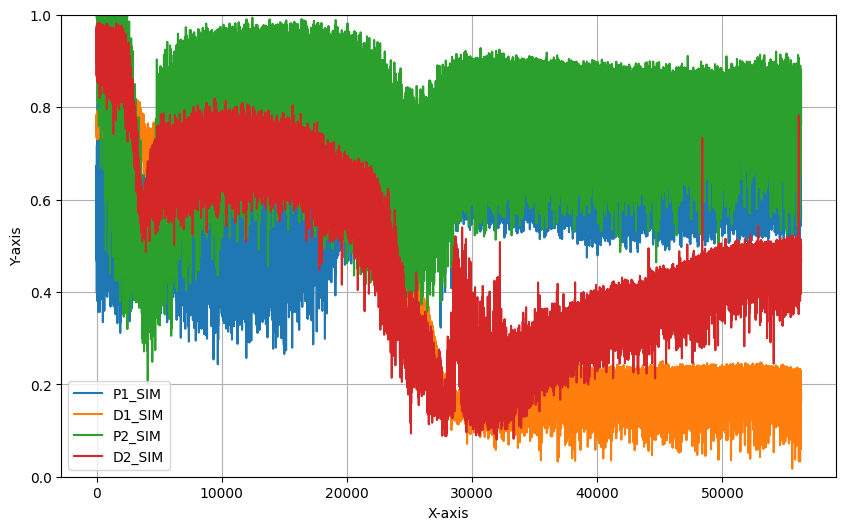

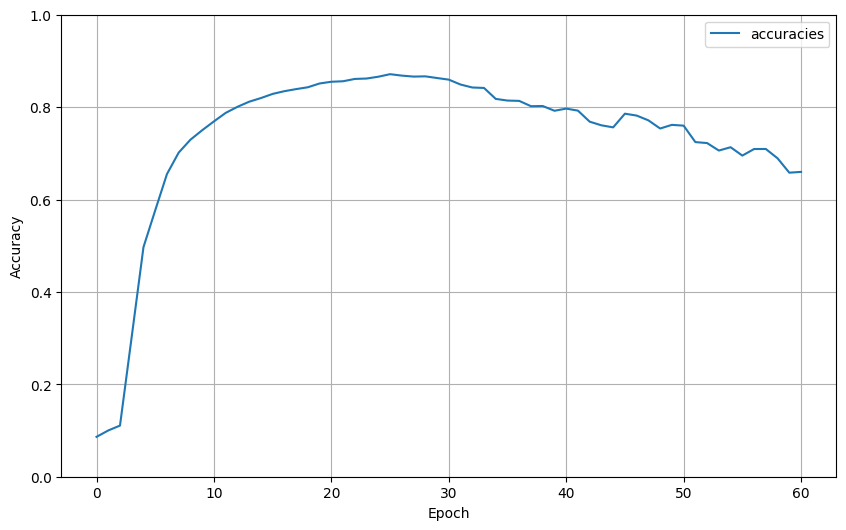

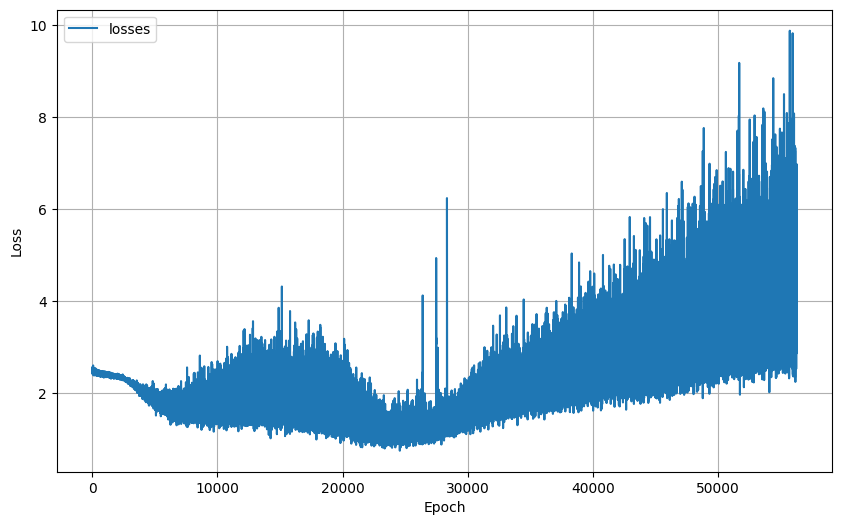

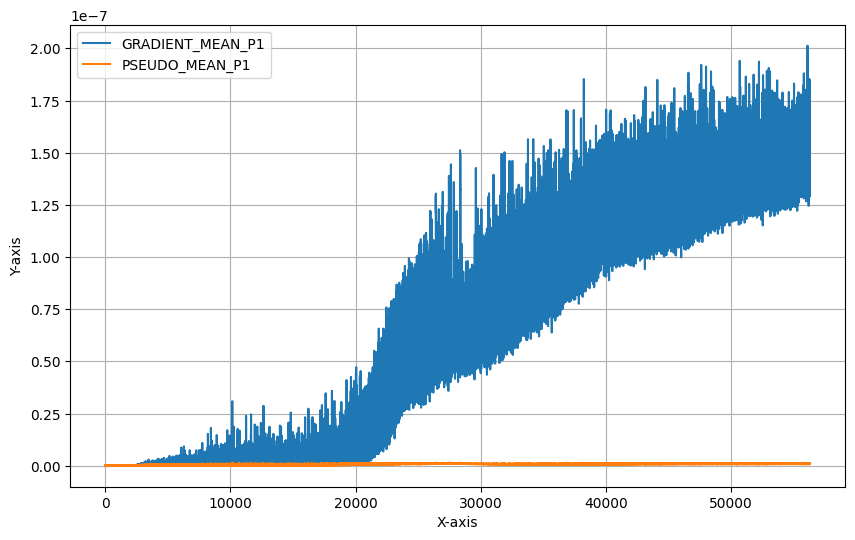

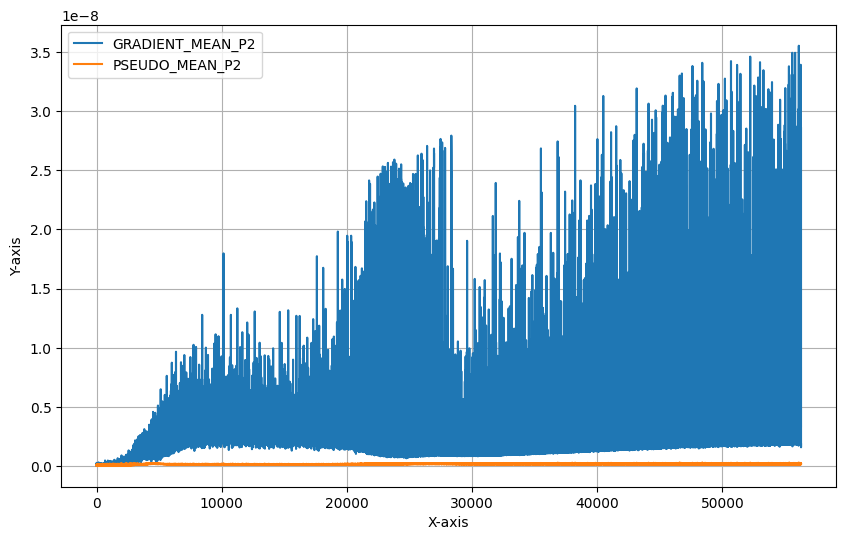

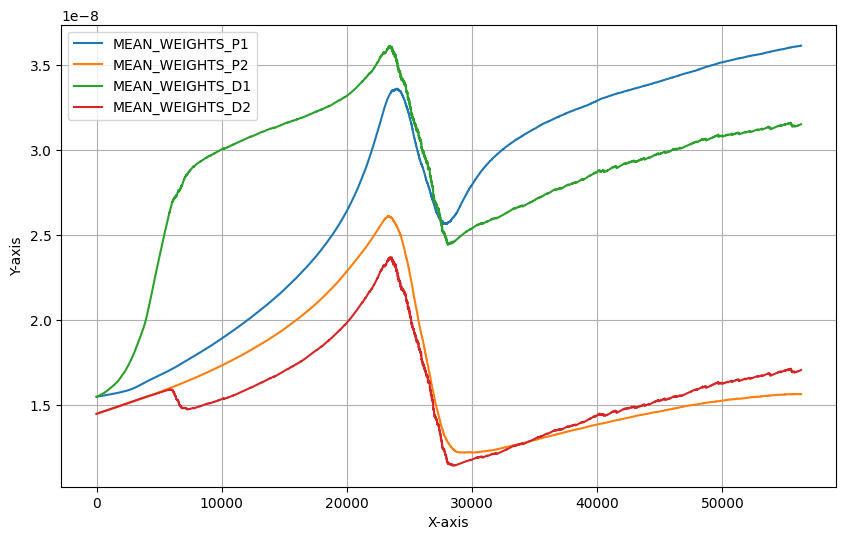

In [75]:

import matplotlib.pyplot as plt

def plot_lists(data, labels=None, title="Plot of Multiple Lists", xlabel="X-axis", ylabel="Y-axis", force=False):
    plt.figure(figsize=(10, 6))
    for i, lst in enumerate(data):
        label = labels[i] if labels and i < len(labels) else f"Series {i+1}"
        plt.plot(lst, label=label)
    if(force): plt.ylim(0,1)
    plt.title("")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def split_tuples(data):
    list1, list2, list3, list4 = zip(*data)
    return list(list1), list(list2), list(list3), list(list4)

L1, L2, L3, L4 = split_tuples(SIMILARITIES)
data = [L1, L2, L3, L4]
labels = ["P1_SIM", "D1_SIM", "P2_SIM", "D2_SIM"]
plot_lists(data, labels, force=True)

data = [accuracies]
labels = ["accuracies"]
plot_lists(data, labels, title="Accuracy vs Epoch", xlabel="Epoch", ylabel="Accuracy", force=True)

data = [losses]
labels = ["losses"]
plot_lists(data, labels, title="Loss vs Epoch", xlabel="Epoch", ylabel="Loss")

data = [GRADIENT_MEAN_P1, PSEUDO_MEAN_P1]
labels = ["GRADIENT_MEAN_P1", "PSEUDO_MEAN_P1"]
plot_lists(data, labels)

data = [GRADIENT_MEAN_P2, PSEUDO_MEAN_P2]
labels = ["GRADIENT_MEAN_P2","PSEUDO_MEAN_P2"]
plot_lists(data, labels)

L1, L2, L3, L4 = split_tuples(WEIGHT_MEANS)
data = [L1, L2, L3, L4]
labels = ["MEAN_WEIGHTS_P1", "MEAN_WEIGHTS_P2", "MEAN_WEIGHTS_D1", "MEAN_WEIGHTS_D2"]
plot_lists(data, labels)


# data = [CLIPPED1, CLIPPED2]
# labels = ["CLIPPED1", "CLIPPED2"]
# plot_lists(data, labels)





In [ ]:
# model = torch.load("/kaggle/input/mnistclassifier/pytorch/default/1/model_23.pth", weights_only=False)
device = torch.device("cuda")

true_labels = []
predictions = []
with torch.no_grad():
    total_correct = 0
    total_predictions = 0
    for test_imgs, test_labels in test_loader: 
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_preds = model(test_imgs)
        predicted = torch.argmax(test_preds, dim=1)
        total_correct += (predicted == test_labels).sum().item()
        total_predictions += test_labels.size(0)

        true_labels.append(test_labels)
        predictions.append(predicted)
    accuracy = total_correct / total_predictions
print(f"Accuracy: {accuracy}")
true_labels = torch.cat(true_labels)
predictions = torch.cat(predictions)

print(true_labels.shape, predictions.shape)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(labels, predictions, normalize=False):
    cm = confusion_matrix(labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.show()

plot_confusion_matrix(true_labels.cpu().tolist(), predictions.cpu().tolist())